# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Описание представленных данных:**
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

*План работы:*
- предобработка данных (заполнение пропусков, замена типов данных и т.д.)
- расчет дополнительных параметров необходимых для исследовательского анализа
- исследовательский анализ

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = 200 #отображение максимального количества столбцов: 200

In [3]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('C:/Users/admin/Desktop/ЯндексПрактикум/1 часть/Исследовательский анализ данных. Объявления о продаже квартир/real_estate_data.csv', sep='\t')
    
data2 = data.copy().reset_index()
#data.head(50)

In [4]:
data.info() #общая инф-ция массива

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
print('Явных дубликатов:', data.duplicated().sum())#проверка на наличие явных дубликатов

Явных дубликатов: 0


### Вывод

Заметил такие особенности:
- название столбца cityCenters_nearest
- формат в first_day_exposition    
- в столбцах имеются вещественные числа, там где они не нужны: last_price (значения после запятой не сильно повлияют на результат); floors_total (кол-во этажей не бывает не целых чисел); balcony; airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest (думаю, что погода от лишнего метра не измениться, а объем данных сократится); parks_around3000, ponds_around3000; days_exposition
- необходимо поменять формат даты в столбце first_day_exposition  
- в столбце ceiling_height имеются пропуски. Я бы заменил их на мединные, т.к. если квартиры с 4-х метровыми потолками, а это редкость
- в столбце floors_total буду менять нулевые значения на медианные, средние или на значения из столбца floor (еще не решил), т.к. есть квартиры на 22 этаже с пустым столбцом floors_total
- в столбце living_area, kitchen_area есть пропуски и буду их заменять на медианные, т.к. есть разброс значений
- в столбце is_apartment есть пропуски, к тому же тип значений - строки. Буду менять тип на bool, а пропуски на False
- в столбце balcony есть пропуски и буду заменять на 0, т.к. просто отсутсвуют балконы
- в столбце locality_name пропуски по населенным пунктам и пропусков всего 49. Думаю, что такое значение мало повлияет на рез-т
- пропуски в столбцах airports_nearest, cityCenters_nearest буду заполнять медианными, т.к. большая выборка
- заметил, что столбцы parks_around3000 и parks_nearest соотносятся. Если в parks_around3000 стоит 0 или пропуск, то в parks_nearest также есть пропуск. В столбце parks_around3000 пропуски буду заменять на 0. Возможно, забыли указать, как в случае с балконами. Такая же ситуация со столбцами ponds_around3000 и ponds_nearest. Столбцы parks_nearest и ponds_nearest заменю на 3001м
- пропуски в столбце days_exposition заполню медианными значениями

## Предобработка данных

In [6]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}) # поменял название столбца cityCenters_nearest
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #изменил формат даты
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### Заполнение пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23699 non-null  int64         
 1   last_price               23699 non-null  float64       
 2   total_area               23699 non-null  float64       
 3   first_day_exposition     23699 non-null  datetime64[ns]
 4   rooms                    23699 non-null  int64         
 5   ceiling_height           14504 non-null  float64       
 6   floors_total             23613 non-null  float64       
 7   living_area              21796 non-null  float64       
 8   floor                    23699 non-null  int64         
 9   is_apartment             2775 non-null   object        
 10  studio                   23699 non-null  bool          
 11  open_plan                23699 non-null  bool          
 12  kitchen_area             21421 n

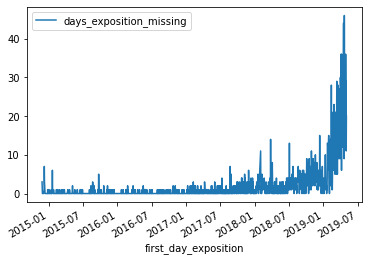

In [7]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

data['days_exposition_missing'] = data['days_exposition'].isna()

data.groupby('first_day_exposition').agg({'days_exposition_missing': 'sum'}).plot()

# Заполнение пропусков
data['city_centers_nearest'] = data['city_centers_nearest'].fillna(data.groupby('locality_name')['city_centers_nearest'].transform('median'))

data.info()

In [8]:
data['floors_total'] = data['floors_total'].fillna(data['floor']) # замена пропуска в столбце floors_total на значение из столбца floor 

columns_for_median = ['ceiling_height', 'living_area', 'kitchen_area', 'days_exposition', 'city_centers_nearest'] #список столбцов, где пропуски заменяются на медиану

for column in columns_for_median: #цикл, проходящий по списку
    data[column] = data[column].fillna(data[column].median())
    
columns_for_zero = ['balcony', 'parks_around3000', 'ponds_around3000'] #список столбцов, где пропуски заменяются на 0
for column2 in columns_for_zero: #цикл, проходящий по списку 
    data[column2] = data[column2].fillna(0)
   
data['is_apartment'] = data['is_apartment'].fillna(False) # замена пропуска в столбце is_apartment на False


In [9]:
# заполнение столбца city_centers_nearest медианой, сгруппированный по locality_name

data['city_centers_nearest'] = data['city_centers_nearest'].fillna(data.groupby('locality_name')['city_centers_nearest'].transform("median"))


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23699 non-null  int64         
 1   last_price               23699 non-null  float64       
 2   total_area               23699 non-null  float64       
 3   first_day_exposition     23699 non-null  datetime64[ns]
 4   rooms                    23699 non-null  int64         
 5   ceiling_height           23699 non-null  float64       
 6   floors_total             23699 non-null  float64       
 7   living_area              23699 non-null  float64       
 8   floor                    23699 non-null  int64         
 9   is_apartment             23699 non-null  bool          
 10  studio                   23699 non-null  bool          
 11  open_plan                23699 non-null  bool          
 12  kitchen_area             23699 n

### Перевод данных в нужный тип

In [11]:
# перевод столбцов в другой тип данных
columns_float = ['last_price', 'floors_total', 'balcony', 'city_centers_nearest', 
                 'parks_around3000', 'ponds_around3000', 'days_exposition'] 
for column4 in columns_float:
    data[column4] = data[column4].astype('int')


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23699 non-null  int64         
 1   last_price               23699 non-null  int32         
 2   total_area               23699 non-null  float64       
 3   first_day_exposition     23699 non-null  datetime64[ns]
 4   rooms                    23699 non-null  int64         
 5   ceiling_height           23699 non-null  float64       
 6   floors_total             23699 non-null  int32         
 7   living_area              23699 non-null  float64       
 8   floor                    23699 non-null  int64         
 9   is_apartment             23699 non-null  bool          
 10  studio                   23699 non-null  bool          
 11  open_plan                23699 non-null  bool          
 12  kitchen_area             23699 n

### Вывод
- заполнил пропуски медианным значением, либо нулевым, в зависимости от столбца
- заменил вещественные числа на целочисленные, т.к. в них нет необходимости 

## Расчёты и добавление результатов в таблицу

In [13]:
data['metr_price'] = data['last_price'] / data['total_area'] #добавление столбца цены за 1 кв. метр


data['year_exposition'] = data['first_day_exposition'].dt.year #добавление года в таблицу
data['month_exposition'] = data['first_day_exposition'].dt.month #добавление месяца в таблицу
data['day_exposition'] = data['first_day_exposition'].dt.weekday #добавление дня в таблицу


def floor_type(row): #функция для добавления категории этажа
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1)
#data

data['area_living_to_total'] = data['living_area']/data['total_area'] #добавление столбца с отношениями жилой площади к общей
data['area_kitchen_to_living'] = data['kitchen_area']/data['living_area'] #добавление столбца с отношениями площади кухни к жилой



### Вывод

- произвел расчет стоимости квадратного метра квартиры
- добавил отдельные столбцы: год, месяц, день
- добавил столбцы с отношением жилой площади к общей и с отношением площади кухни к жилой

## Исследовательский анализ данных

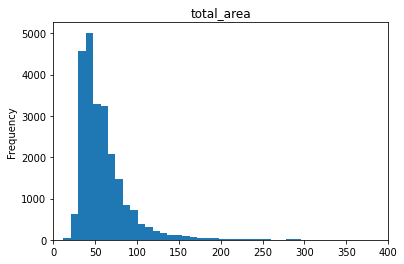

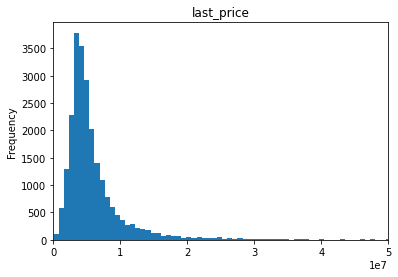

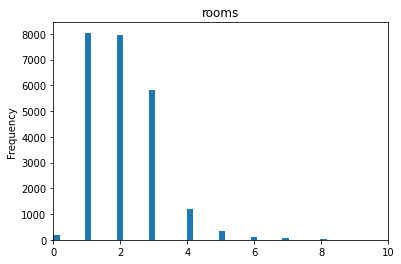

<AxesSubplot:title={'center':'ceiling_height'}, ylabel='Frequency'>

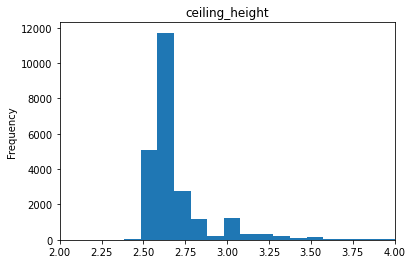

In [14]:
# строю гистограммы для ['total_area', 'last_price', 'rooms', 'ceiling_height'] 
data['total_area'].plot(kind='hist', bins=100, title='total_area', xlim=(0,400))
plt.show()
data['last_price'].plot(kind='hist', bins=1000, title='last_price', xlim=(0,50000000))
plt.show()
data['rooms'].plot(kind='hist', bins=100, title='rooms', xlim=(0,10))
plt.show()
data['ceiling_height'].plot(kind='hist', bins=1000, title='ceiling_height', xlim=(2,4))

- в столбце total_area частоста квартир больше 200 м2 уменьшается. Думаю, можно будет сделать срез до 200 м2
- в столбце last_price в основном квартиры до 30 млн рублей
- в основном чаще встречаются квартиры до 3x комнат
- в оcновном квартиры с потолком до 3х метров

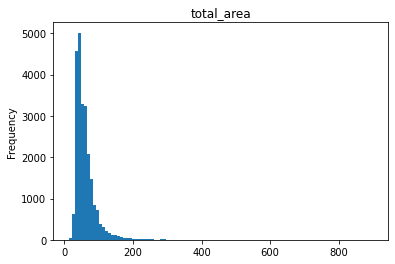

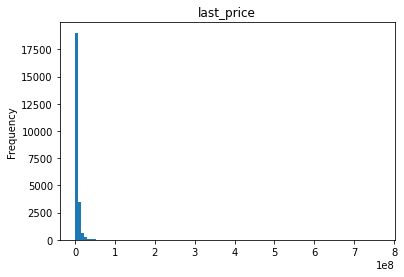

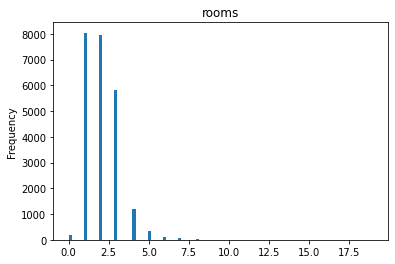

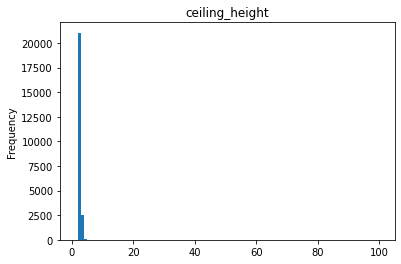

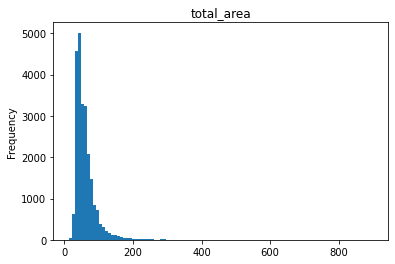

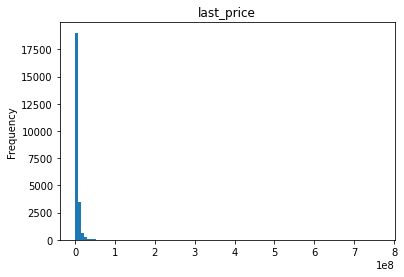

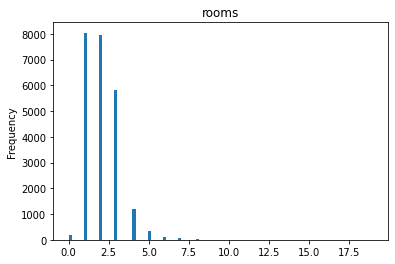

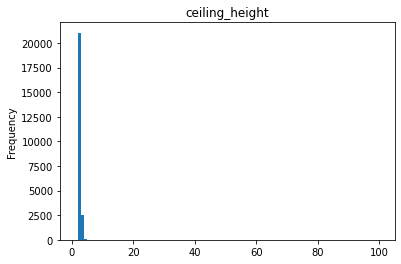

In [15]:
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height'] 
def function(df):
    for column in columns:
        df[column].plot(kind='hist', bins=100, title=column)
        plt.show()
        
function(data)

# Можно еще так
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']

def function(df, col):
    df[col].plot(kind='hist', bins=100, title=col)
    plt.show()
    
for column in columns:
    function(data, column)
        


Медианное значение столбца days_exposition: 95.0
Среднее значение столбца days_exposition: 169.36022616988058


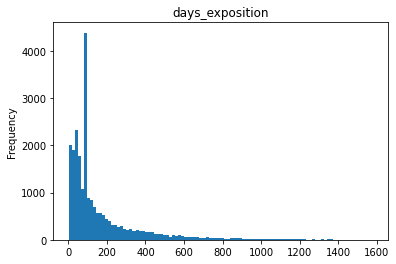

In [16]:
data['days_exposition'].plot(kind='hist', bins=100, title='days_exposition')
print('Медианное значение столбца days_exposition:', data['days_exposition'].median())
print('Среднее значение столбца days_exposition:', data['days_exposition'].mean())

- в среднем время продажи составляют 169 дней
- после 900 дней линия сливается с осью и эти значения редки
- считаю, что до 100 дней продажи можно считать быстрыми, а после уже долгими

In [17]:
# по полученным гистограммам делаю срезы

percent_discarding_values = (len(data) - len(data.query(
                   '(total_area <= 200) & (last_price <= 30000000) & (rooms <= 5) & (2.5 <= ceiling_height <= 3.5) & (days_exposition <= 900)'))) / len(data)
print('Доля отброшенных данных составляет:', percent_discarding_values)
data = data.query(
                   '(total_area <= 200) & (last_price <= 30000000) & (rooms <= 5) & (2.5 <= ceiling_height <= 3.5) & (days_exposition <= 900)')
#data

Доля отброшенных данных составляет: 0.04987552217393139


**Зависимость цены  от площади, числа комнат, удалённости от центра**

Коэффицент корреляции зависимости общей площади от цены: 0.7810179329068739
Коэффицент корреляции зависимости числа комнат от цены: 0.477321889926467
Коэффицент корреляции зависимости расстояния до центра от цены: -0.27199921853831704


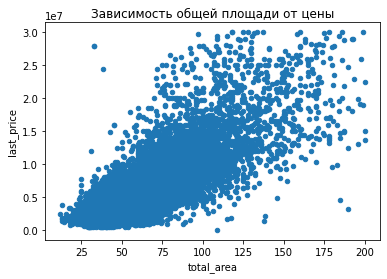

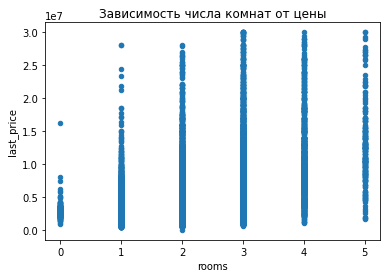

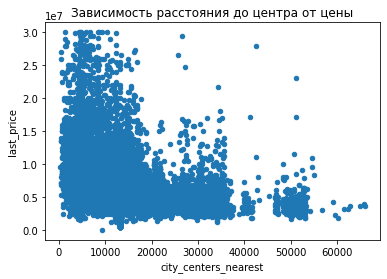

In [18]:
data.plot(x='total_area', y='last_price', kind='scatter', title='Зависимость общей площади от цены') #от общей площади
data.plot(x='rooms', y='last_price', kind='scatter', title='Зависимость числа комнат от цены') #от числа комнат
data.plot(x='city_centers_nearest', y='last_price', kind='scatter', title='Зависимость расстояния до центра от цены') #от удаленности от центра

print('Коэффицент корреляции зависимости общей площади от цены:', data['total_area'].corr(data['last_price']))
print('Коэффицент корреляции зависимости числа комнат от цены:', data['rooms'].corr(data['last_price']))
print('Коэффицент корреляции зависимости расстояния до центра от цены:', data['city_centers_nearest'].corr(data['last_price']))

По графикам можно сказать, что с увеличением общей площади квартиры, стоимость квартиры увеличивается (положительная корреляция). Можно заметить увеличение кол-ва дорогих квартир с ростом кол-ва комнат, но увеличение продолжается до 3х-комнатных квартир. В случае с расстоянием до центра, видим, что с уменьшением расстояния, увеличивается кол-во дорогих квартир.

**Зависимость цены  от этажа квартиры**

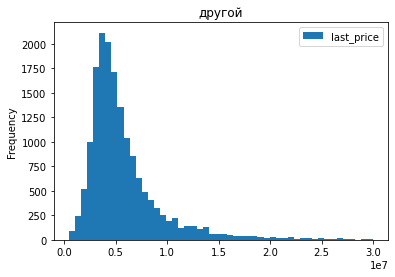

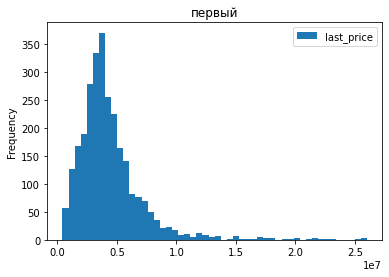

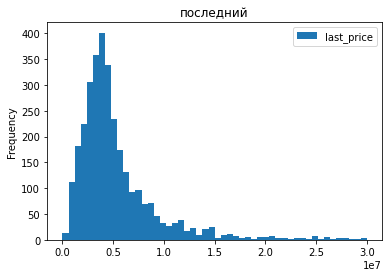

In [19]:
for name, group_data in data.groupby('floor_type'):
    group_data.plot(kind='hist', y='last_price', title=name, bins=50)    

Распределение цен по этажам выглядит более-менее одинаково и трудно делать категоричные выводы.

**Зависимость цены от даты размещения: дня недели, месяца и года**

<AxesSubplot:title={'center':'Зависимость года от цены'}, xlabel='year_exposition', ylabel='last_price'>

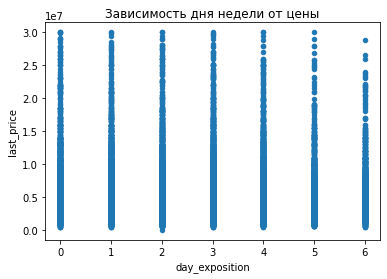

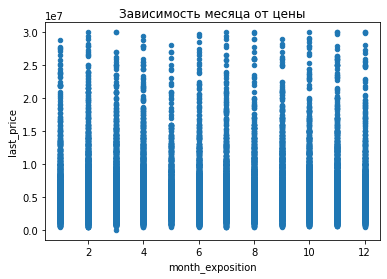

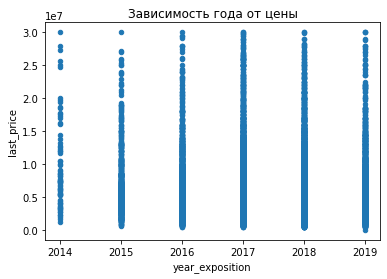

In [20]:
data.plot(x='day_exposition', y='last_price', kind='scatter', title='Зависимость дня недели от цены') # от дня недели
data.plot(x='month_exposition', y='last_price', kind='scatter', title='Зависимость месяца от цены') # от месяца
data.plot(x='year_exposition', y='last_price', kind='scatter', title='Зависимость года от цены') # от месяца

Видно, что под конец недели цены отличаются от цен в начале недели. Скорее всего это связано с выходными днями. В зависимости от месяца, цены не стабильны. Видно, что цены в зависимости от года растут до 2017, потом идёт некий спад в цене.  

**Какие факторы больше всего влияют на стоимость квартиры?**

Безусловно, на ценообразование влияет площадь квартиры, расстояние до центра, а также кол-во комнат до определенного момента. По этажности, возможно, есть различие в цене, но не существенное. Активность людей под конец рабочей недели снижается и, следовательно, цены в начале недели отличаются от цен в конце недели.   

**10 населённых пунктов с наибольшим числом объявлений**

In [21]:
#data.head()

In [22]:
locality_meter_count = data.pivot_table(index='locality_name', values='metr_price', aggfunc=['mean', 'count']) #создаю сводную таблицу по местности с расчетом средней цены квадртаного метра и общего кол-ва объявлений
locality_meter_count.columns = ['metr_average', 'count'] #меняю название столбцов
locality_top = locality_meter_count.sort_values('count', ascending=False).head(10)
locality_top.sort_values('metr_average', ascending=False)

,metr_average,count
locality_name,,
Санкт-Петербург,110364.774365,14741
Пушкин,102676.669150,347
деревня Кудрово,92524.863731,291
посёлок Парголово,90333.345674,321
посёлок Мурино,85885.906971,511
посёлок Шушары,78593.200186,435
Колпино,75282.078513,333
Гатчина,69021.537558,300
Всеволожск,68695.773206,389


В СПБ самая дорогая среднестатистическая жилая площадь из топ-10, в Выборге - самая дешевая.

**Какая область входит в центр?**

In [23]:
data3 = data.copy()
city_center = data3.query('locality_name == "Санкт-Петербург"').reset_index() # делаю срез по СПБ

city_center['city_center_km'] =  round(city_center['city_centers_nearest'] / 1000).astype('int') # добавляю столбец с расстоянием до центра в км
city_center.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_missing,metr_price,year_exposition,month_exposition,day_exposition,floor_type,area_living_to_total,area_kitchen_to_living,city_center_km
0,0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028,1,482.0,2,755.0,95,True,120370.370370,2019,3,3,другой,0.472222,0.490196,16
1,2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933,1,90.0,2,574.0,558,False,92785.714286,2015,8,3,другой,0.612500,0.241983,14
2,4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098,2,112.0,1,48.0,121,False,100000.000000,2018,6,1,другой,0.320000,1.281250,8
3,7,5,7915000,71.6,2019-04-18,2,2.65,24,30.0,22,False,False,False,18.9,2,Санкт-Петербург,23982.0,11634,0,NaN,0,NaN,95,True,110544.692737,2019,4,3,другой,0.418994,0.630000,12
4,9,18,5400000,61.0,2017-02-26,3,2.50,9,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008,0,NaN,0,NaN,289,False,88524.590164,2017,2,6,другой,0.714754,0.149083,15


In [24]:
data3 = data
city_center = data3.query('locality_name == "Санкт-Петербург"').reset_index() # делаю срез по СПБ

city_center['city_center_km'] =  round(city_center['city_centers_nearest'] / 1000).astype('int') # добавляю столбец с расстоянием до центра в км
city_center.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_missing,metr_price,year_exposition,month_exposition,day_exposition,floor_type,area_living_to_total,area_kitchen_to_living,city_center_km
0,0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028,1,482.0,2,755.0,95,True,120370.370370,2019,3,3,другой,0.472222,0.490196,16
1,2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933,1,90.0,2,574.0,558,False,92785.714286,2015,8,3,другой,0.612500,0.241983,14
2,4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098,2,112.0,1,48.0,121,False,100000.000000,2018,6,1,другой,0.320000,1.281250,8
3,7,5,7915000,71.6,2019-04-18,2,2.65,24,30.0,22,False,False,False,18.9,2,Санкт-Петербург,23982.0,11634,0,NaN,0,NaN,95,True,110544.692737,2019,4,3,другой,0.418994,0.630000,12
4,9,18,5400000,61.0,2017-02-26,3,2.50,9,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008,0,NaN,0,NaN,289,False,88524.590164,2017,2,6,другой,0.714754,0.149083,15


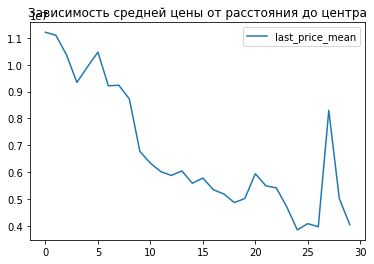

In [25]:
price_km = city_center.pivot_table(index='city_center_km', values='last_price') #сводная таблица для каждого км
price_km.columns=['last_price_mean'] #меняю название столбца

plt.plot(price_km) #вывожу зависимость средней цены от расстояния
plt.legend(price_km.columns)
plt.title('Зависимость средней цены от расстояния до центра')
plt.show()

По графику предположу, что центральная зона - это зона, в радиусе 7 км.

**Cегмент квартир в центре**

In [26]:
city_center_segment = city_center.query('city_center_km <= 7') #получаю сегмент квартир в центре
city_center_segment.head(5)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_missing,metr_price,year_exposition,month_exposition,day_exposition,floor_type,area_living_to_total,area_kitchen_to_living,city_center_km
13,24,8,6500000,97.2,2015-10-31,2,2.65,3,46.5,1,False,False,False,19.6,0,Санкт-Петербург,20052.0,2336,3,411.0,3,124.0,265,False,66872.427984,2015,10,5,первый,0.478395,0.421505,2
21,35,6,15500000,149.0,2017-06-26,5,2.65,5,104.0,4,False,False,False,17.0,0,Санкт-Петербург,23670.0,3502,0,NaN,1,779.0,644,False,104026.845638,2017,6,0,другой,0.697987,0.163462,4
36,61,18,7990000,74.0,2017-08-24,2,2.65,4,43.0,4,False,False,False,20.0,0,Санкт-Петербург,22568.0,4288,1,363.0,0,NaN,609,False,107972.972973,2017,8,3,последний,0.581081,0.465116,4
37,63,2,20000000,118.0,2018-09-11,3,3.00,9,68.0,7,False,False,False,16.0,0,Санкт-Петербург,26055.0,4800,1,648.0,1,779.0,37,False,169491.525424,2018,9,1,другой,0.576271,0.235294,5
49,94,3,3500000,29.5,2019-04-26,1,2.50,5,15.6,2,False,False,False,5.5,1,Санкт-Петербург,12921.0,7303,0,NaN,0,NaN,4,False,118644.067797,2019,4,4,другой,0.528814,0.352564,7


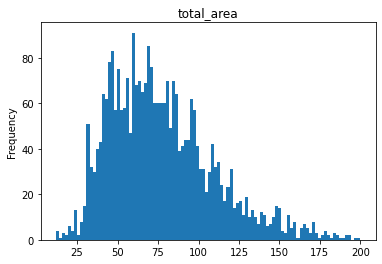

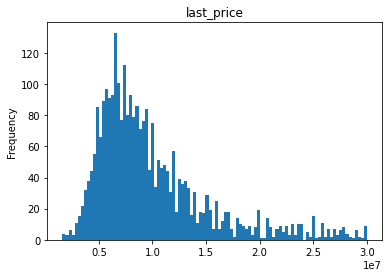

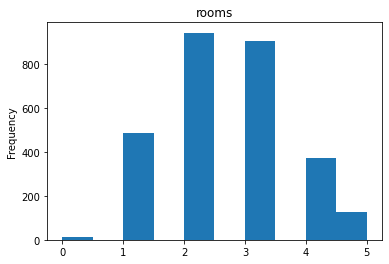

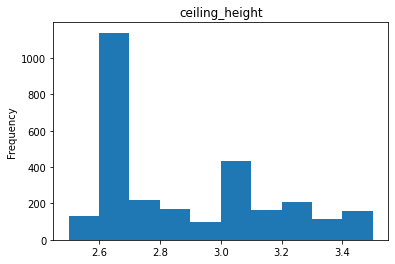

In [27]:
#гистограммы для квартир в центре
city_center_segment['total_area'].plot(kind='hist', bins=100, title='total_area')
plt.show()
city_center_segment['last_price'].plot(kind='hist', bins=100, title='last_price')
plt.show()
city_center_segment['rooms'].plot(kind='hist', bins=10, title='rooms')
plt.show()
city_center_segment['ceiling_height'].plot(kind='hist', bins=10, title='ceiling_height')
plt.show()

- в центре большое количество квартир от 40 до 100м2, тогда как в общем ДФ - от 30 до 70м2
- в центре преобладают цены от 5 до 10 млн, в общем ДФ - от 3 до 7 млн
- в центре преобладают 2 и 3х комнатные квартиры, в общем ДФ - 1 и 2х комнатные квартиры
- в центре большое кол-во квартир с потолками 2.7м, но также имеются стабильные показатели квартир с потолками до 3.5м, в общем ДФ - высота от 2.5 до 2.8м

**Зависимость цены от даты размещения: дня недели, месяца и года для квартир в центре**

<AxesSubplot:title={'center':'Зависимость года от цены'}, xlabel='year_exposition', ylabel='last_price'>

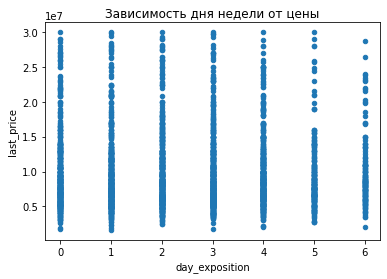

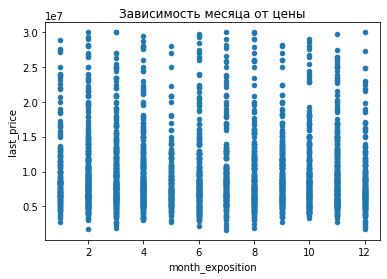

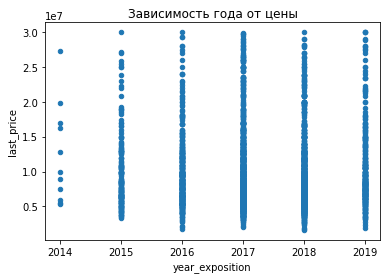

In [28]:
city_center_segment.plot(x='day_exposition', y='last_price', kind='scatter', title='Зависимость дня недели от цены') # от дня недели
city_center_segment.plot(x='month_exposition', y='last_price', kind='scatter', title='Зависимость месяца от цены') # от месяца
city_center_segment.plot(x='year_exposition', y='last_price', kind='scatter', title='Зависимость года от цены') # от месяца

Зависимость даты от цены такая же, как и в общем ДФ

**Зависимость цены  от площади, числа комнат, удалённости от центра для квартир в центре**

Коэффицент корреляции зависимости общей площади от цены: 0.7182383256520554
Коэффицент корреляции зависимости числа комнат от цены: 0.40813081345370184
Коэффицент корреляции зависимости расстояния до центра от цены: -0.06355977587765266


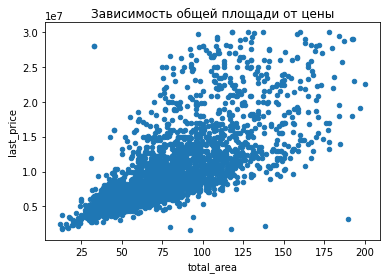

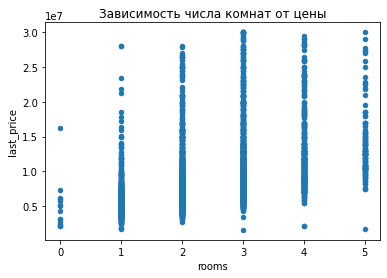

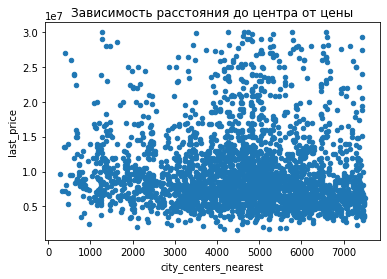

In [29]:
city_center_segment.plot(x='total_area', y='last_price', kind='scatter', title='Зависимость общей площади от цены') #от общей площади
city_center_segment.plot(x='rooms', y='last_price', kind='scatter', title='Зависимость числа комнат от цены') #от числа комнат
city_center_segment.plot(x='city_centers_nearest', y='last_price', kind='scatter', title='Зависимость расстояния до центра от цены') #от удаленности от центра

print('Коэффицент корреляции зависимости общей площади от цены:', city_center_segment['total_area'].corr(city_center_segment['last_price']))
print('Коэффицент корреляции зависимости числа комнат от цены:', city_center_segment['rooms'].corr(city_center_segment['last_price']))
print('Коэффицент корреляции зависимости расстояния до центра от цены:', city_center_segment['city_centers_nearest'].corr(city_center_segment['last_price']))

Зависимости общей площади и количества комнат для квартир в центре такие же, как и в общем ДФ. Но в зависимости расстояния до центра от цены видно, что чем дальше от центра, тем больше дорогих квартир. Возможно, это связано с тем, что на малом расстоянии от центра мало жилых помещений.  

**Зависимость цены  от этажа для квартир в центре**

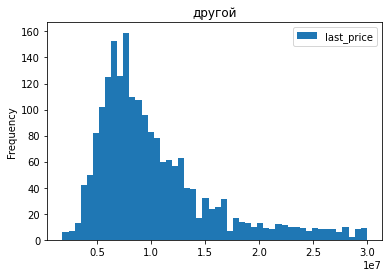

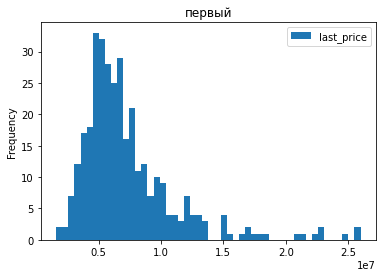

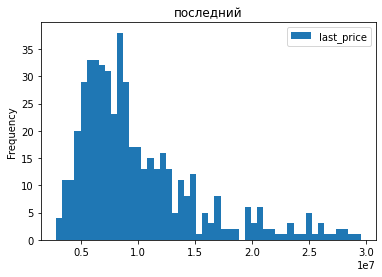

In [30]:
for name, group_data in city_center_segment.groupby('floor_type'):
    group_data.plot(kind='hist', y='last_price', title=name, bins=50)   

Зависимости этажности от цен для квартир в центре похожи на общий ДФ.

## Общий вывод

В заключение скажу, что на ценообразование влияет площадь квартиры, расстояние до центра, а также кол-во комнат до определенного момента. Второстепенные факторы такие, как этажность, день, месяц, год публикации мало влияют на ценообразование. 

Также добавлю, что:
- в центре большое количество квартир от 40 до 100м2, тогда как в общем ДФ - от 30 до 70м2
- в центре преобладают цены от 5 до 10 млн, в общем ДФ - от 3 до 7 млн
- в центре преобладают 2 и 3х комнатные квартиры, в общем ДФ - 1 и 2х комнатные квартиры
- в центре большое кол-во квартир с потолками 2.7м, но также имеются стабильные показатели квартир с потолками до 3.5м, в общем ДФ - высота от 2.5 до 2.8м 